In [1]:
# import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
#tries to replicate the styles from FiveThirtyEight.com.
plt.style.use('fivethirtyeight')

In [2]:
# working with dataset called "Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
data = sm.datasets.co2.load_pandas()
y = data.data

In [3]:
y.head()

co2
1958-03-29  316.1
1958-04-05  317.3
1958-04-12  317.6
1958-04-19  317.5
1958-04-26  316.4

In [4]:
#Weekly data can be tricky to work with since itâ€™s a briefer amount of time, so let's use monthly averages instead.
# The 'MS' string groups the data in buckets by start of the month
y = y['co2'].resample('MS').mean()
y.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [5]:
# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

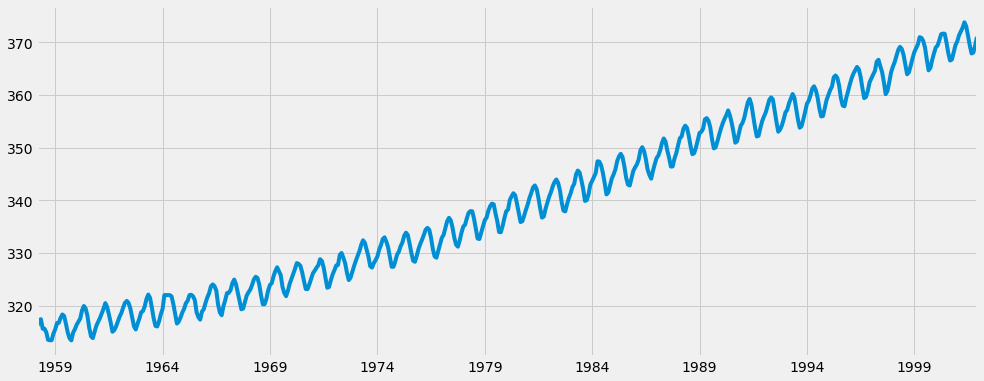

In [6]:
#time series e as a data visualization
y.plot(figsize=(15, 6))
plt.show()

The time series has an obvious seasonality pattern, as well as an overall increasing trend.

# The ARIMA Time Series Model

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for AutoregRessive Integrated Moving Average. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.

There are three distinct integers (p, d, q) that are used to parametriz

1. p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.

2. d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.

3. q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.



When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. 

Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. 

The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved.

# Parameter Selection for the ARIMA Time Series Model

When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest.

We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX().

# select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.

We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest.

In [12]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


The code chunk below iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.



When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. 


AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [14]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
AIC = []
parm_ = []
parm_s = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            AIC.append(results.aic)
            parm_.append(param)
            parm_s.append(param_seasonal)

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624045498
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727641307
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320026
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878500246952
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978072075
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912894922
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048755126321
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327375734
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067330986
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.417471690003
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1082.2618354804601
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.431571168119
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893630987
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912988165787
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194062
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:337.79385490535475
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:619.9501759055394
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:376.9283760499742
A

In [15]:
min(AIC)

277.7802202870399

In [20]:
pos = AIC.index(min(AIC))

In [21]:
parm_[pos]

(1, 1, 1)

In [22]:
parm_s[pos]

(1, 1, 1, 12)

The output of our code suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 277.78. We should therefore consider this to be optimal option out of all the models we have considered.

# Fitting an ARIMA Time Series Model

In [23]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=parm_[pos],
                                seasonal_order=parm_s[pos],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.163      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


In [24]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -133.890
Date:                            Thu, 28 Jun 2018   AIC                            277.780
Time:                                    14:01:30   BIC                            299.107
Sample:                                03-01-1958   HQIC                           286.130
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077   

The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the table of coefficients. 

The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. 


The P>|z| column informs us of the significance of each feature weight. 

Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

# Validating Forecasts

We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

In [25]:
#The code requires the forecasts to start at January 1998
#The dynamic=False argument ensures that we produce one-step ahead forecasts, 
#meaning that forecasts at each point are generated using the full history up to that point.
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

In [33]:
y[y.index >= '1998-01-01'].head()

1998-01-01    365.340
1998-02-01    366.200
1998-03-01    367.375
1998-04-01    368.525
1998-05-01    369.140
Freq: MS, Name: co2, dtype: float64

In [30]:
pred_ci.head()

lower co2   upper co2
1998-01-01  364.453359  365.675237
1998-02-01  365.373492  366.595370
1998-03-01  366.404734  367.626612
1998-04-01  367.908491  369.130368
1998-05-01  368.389515  369.611392

We can plot the real and forecasted values of the CO2 time series to assess how well we did.

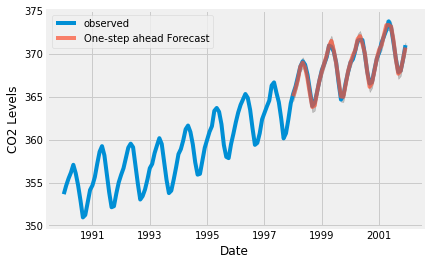

In [42]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.Figure(figsize=(20,8))
plt.show()

Compute the MSE (Mean Squared Error), which summarizes the average error of our forecasts. 

For each predicted value, we compute its distance to the true value and square the result. 

The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [43]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


The MSE of our one-step ahead forecasts yields a value of 0.07, which is very low as it is close to 0. An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.

In the code chunk below, we specify to start computing the dynamic forecasts and confidence intervals from January 1998 onwards.

In [44]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [45]:
pred_dynamic_ci.head()

lower co2   upper co2
1998-01-01  364.453359  365.675237
1998-02-01  365.050219  366.536654
1998-03-01  365.874941  367.529645
1998-04-01  367.090559  368.882984
1998-05-01  367.550502  369.466489

In [46]:
y[y.index >= '1998-01-01'].head()

1998-01-01    365.340
1998-02-01    366.200
1998-03-01    367.375
1998-04-01    368.525
1998-05-01    369.140
Freq: MS, Name: co2, dtype: float64

Plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when using dynamic forecasts. 

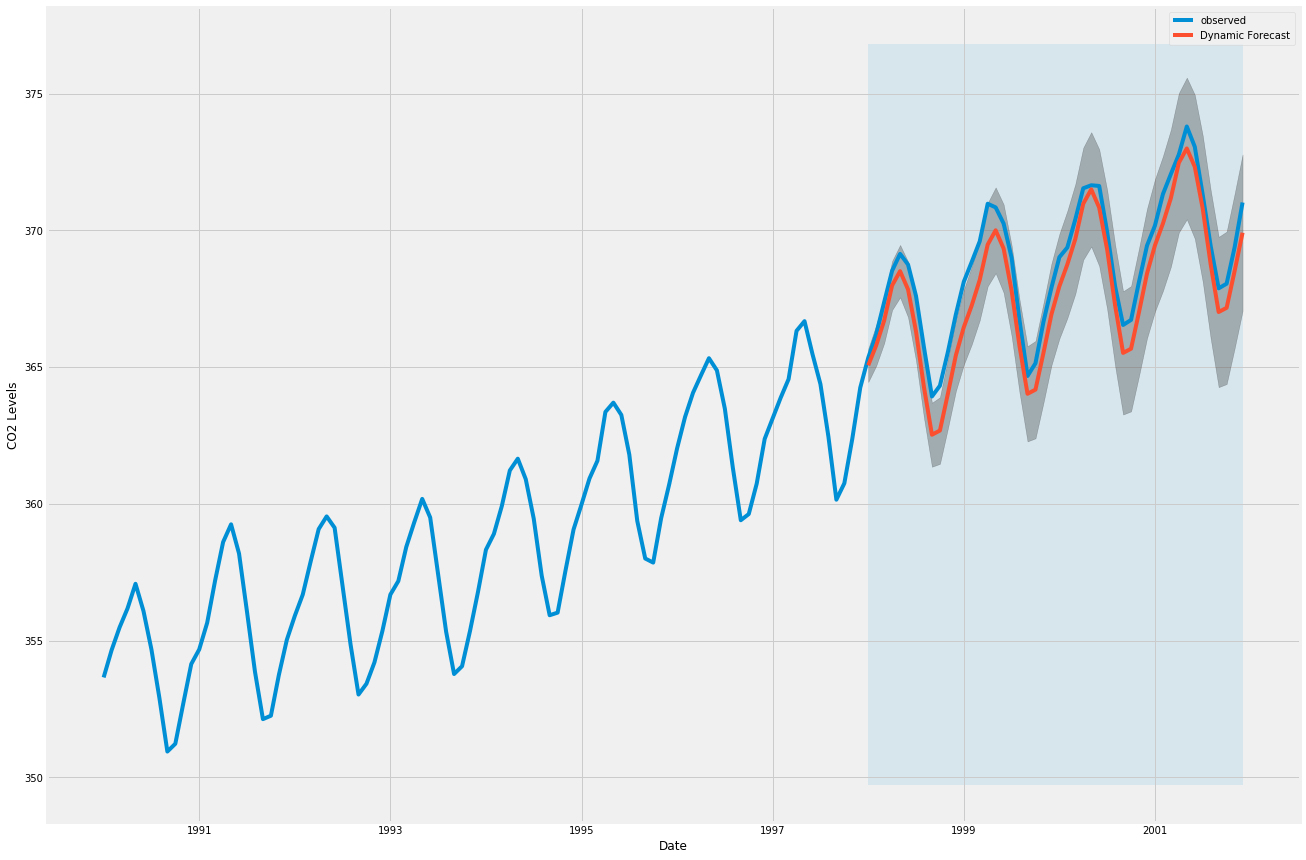

In [47]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

Quantify the predictive performance of our forecasts by computing the MSE

In [48]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


This is slightly higher than the one-step ahead, which is to be expected given that we are relying on less historical data from the time series.

# Producing and Visualizing Forecasts

Leveraging our seasonal ARIMA time series model to forecast future values. 

The get_forecast() attribute of our time series object can compute forecasted values for a specified number of steps ahead.

In [49]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [50]:
pred_ci.head()

lower co2   upper co2
2002-01-01  371.366715  372.588589
2002-02-01  372.005875  373.492306
2002-03-01  372.834951  374.489650
2002-04-01  373.963406  375.755824
2002-05-01  374.387759  376.303741

In [51]:
y.tail()

2001-08-01    369.425
2001-09-01    367.880
2001-10-01    368.050
2001-11-01    369.375
2001-12-01    371.020
Freq: MS, Name: co2, dtype: float64

# Plot the time series and forecasts of its future values.

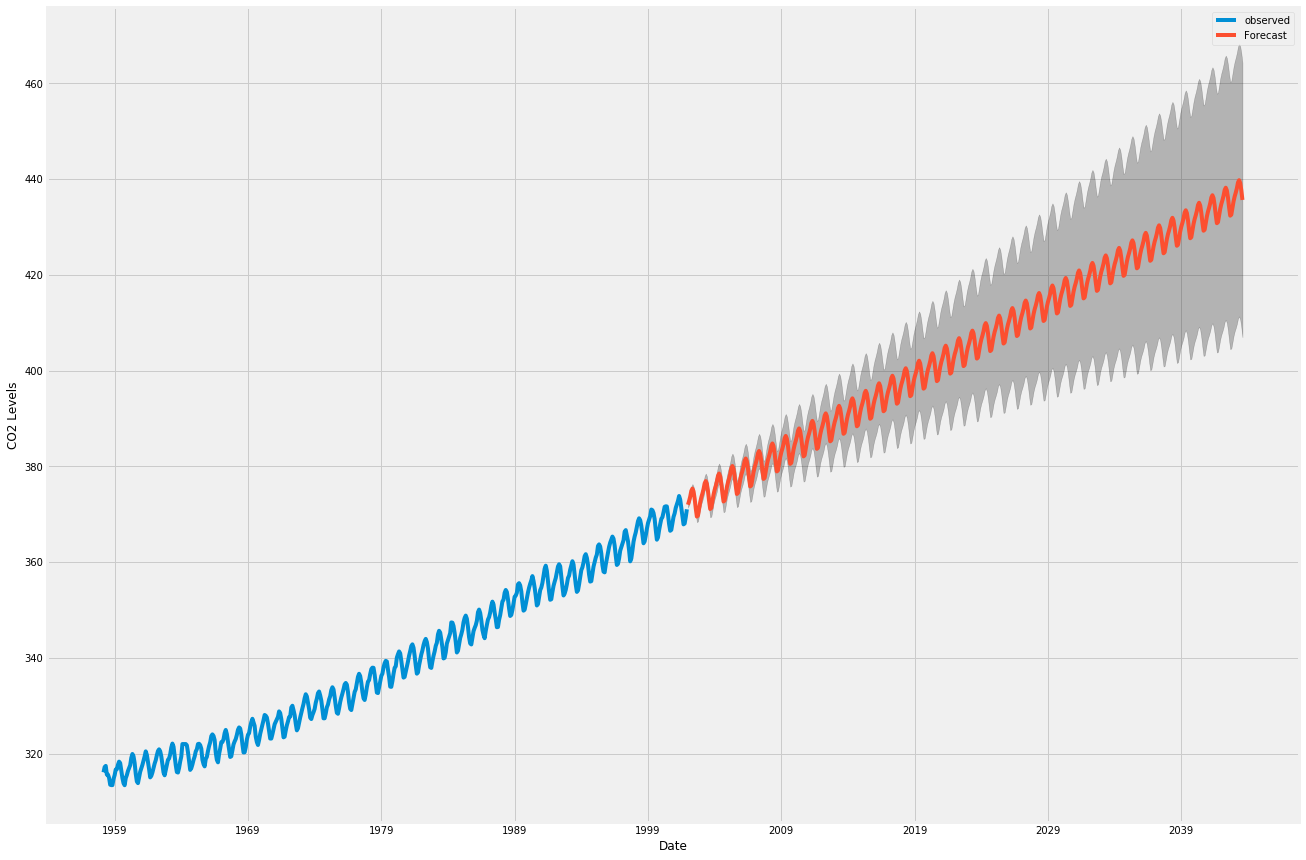

In [52]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

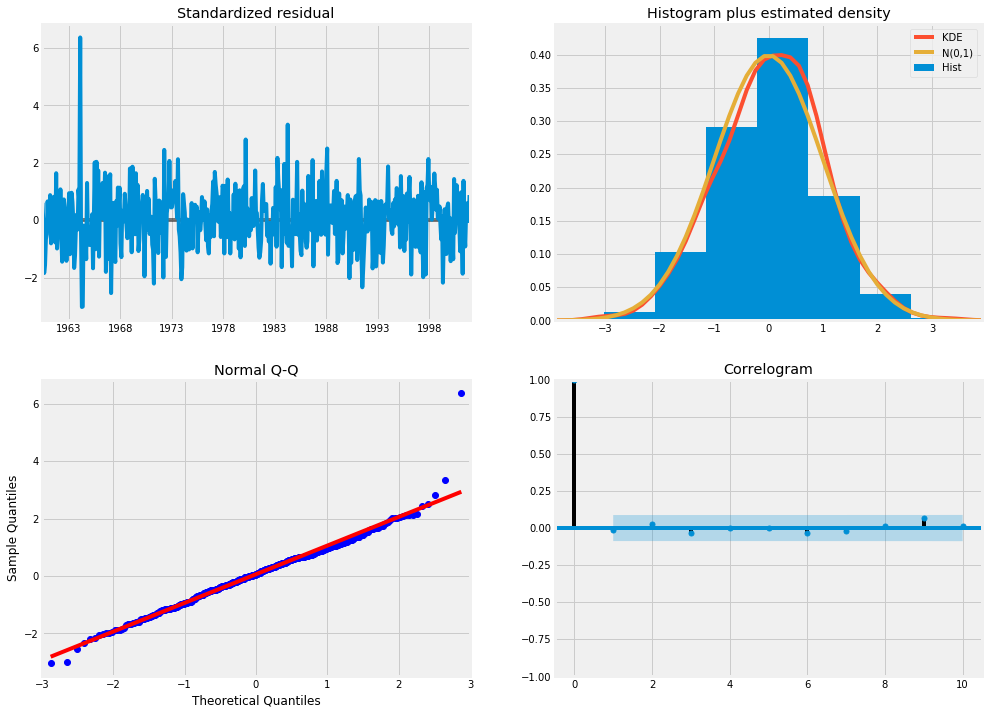

In [53]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [55]:
int(np.log(10000))

9